# **Recognize the shape of objects**

**About Dataset**
- Cào từ trên Bing, Baidu về với nhiều đồ vật thuộc các hình dạng như hình tròn, vuông, tam giác
- Dữ liệu có nhiều kích thước và màu sắc khác nhau
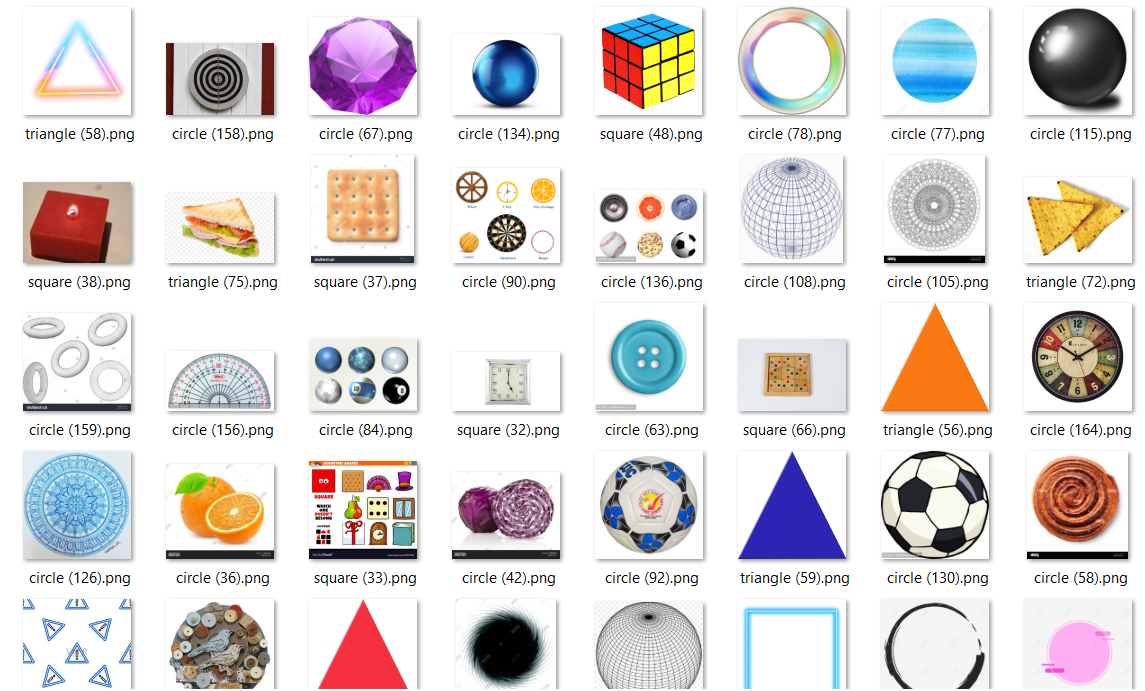

**About Problem**
- Với thời đại tiêu dùng hiện nay thì có rất nhiều mặt hàng được sản xuất vậy nên việc nhận biết và phân loại hình dạng của mỗi món hàng là việc làm cần thiết để tối ưu việc bảo quản, sắp xếp, đóng gói trong các công ty.
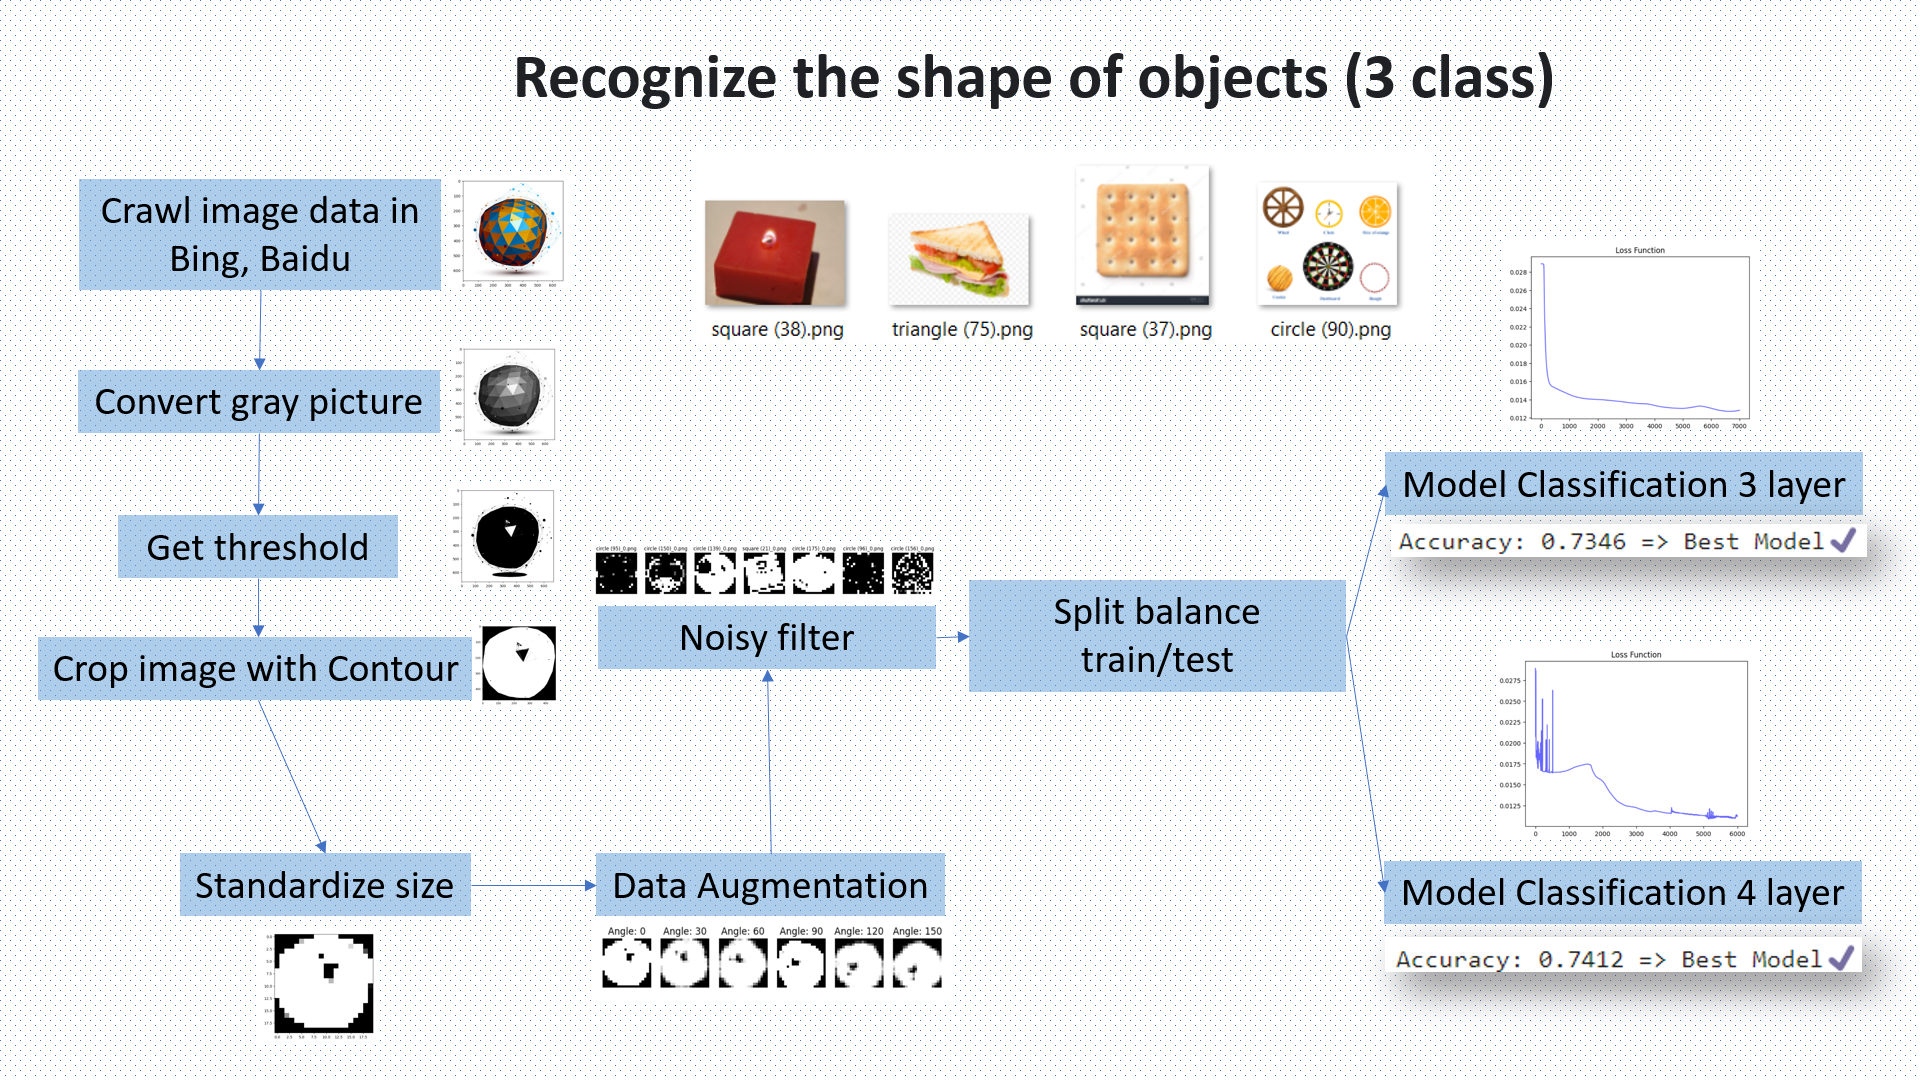

# Import Basic Library

In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Visulization Data Preprocess method

### Read picture

In [2]:
# Mở hình ảnh
img = cv2.imread("/kaggle/input/tptn-object-shape-dataset/object-dataset/all/circle (1).png")
print(img.shape)

(670, 670, 3)


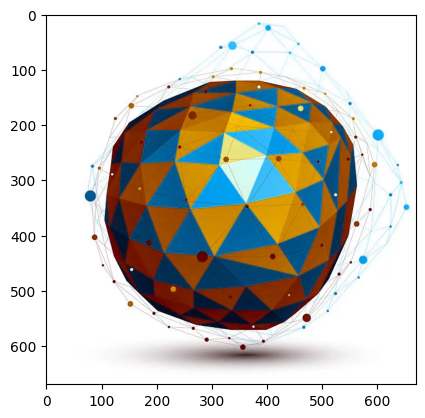

In [3]:
plt.imshow(img)

### Convert color to black and white

In [4]:
# function convert color
grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

(670, 670)


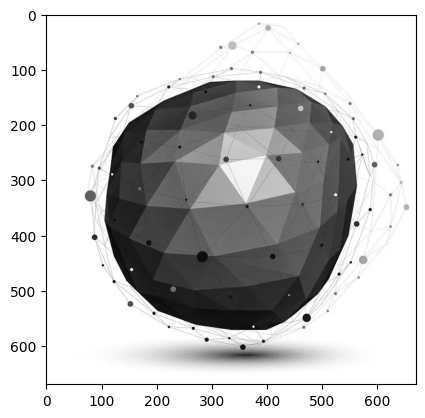

In [5]:
print(grayscale_image.shape)
plt.imshow(grayscale_image, cmap='gray')

### Get Threshold

In [6]:
bin_pixels = cv2.threshold(grayscale_image, 200, 255, cv2.THRESH_BINARY)[1]

(670, 670)


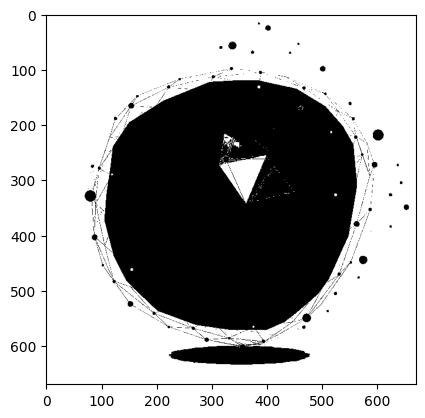

In [7]:
print(bin_pixels.shape)
plt.imshow(bin_pixels, cmap='gray')

### Change black to white, change white to black

In [8]:
bin_pixels = cv2.bitwise_not(bin_pixels)

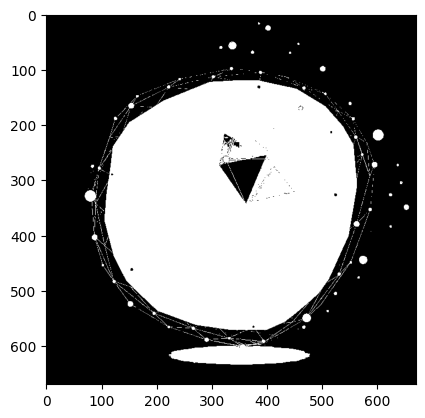

In [9]:
plt.imshow(bin_pixels, cmap='gray')

### Use Contours algorithm to crop picture

In [10]:
contours, _ = cv2.findContours(bin_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
max_contour = max(contours, key=cv2.contourArea)
x, y, w, h = cv2.boundingRect(max_contour)
cropped_img = bin_pixels[y:y+h, x:x+w]
x, y, w, h

(106, 116, 457, 466)

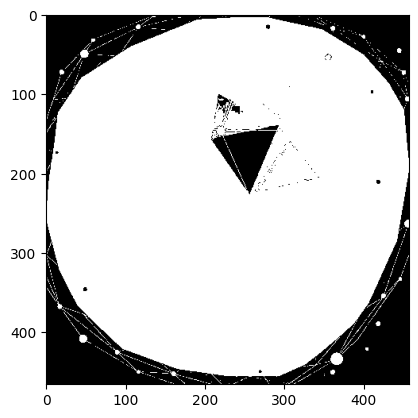

In [11]:
plt.imshow(cropped_img, cmap='gray')

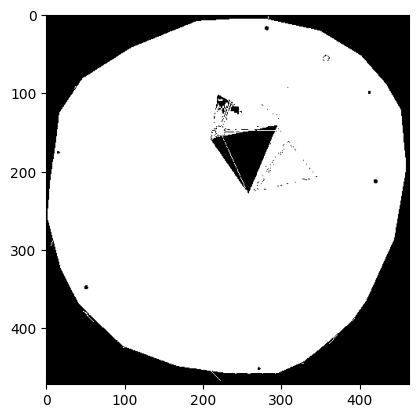

In [12]:
# Make contours around the binarized image, keep only the largest contour
contours, _ = cv2.findContours(bin_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contour = max(contours, key=cv2.contourArea)

# Create a mask from the largest contour
mask = np.zeros(bin_pixels.shape, np.uint8)
cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)

# Use bitwise_and to get masked part of the original image
out = cv2.bitwise_and(bin_pixels, mask)

# get bounding box of contour
# print(contour)
y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])

x1 = int(0.99 * x1)
x2 = int(1.01 * x2)
y1 = int(0.99 * y1)
y2 = int(1.01 * y2)

# if show:
plt.imshow(out[y1:y2, x1:x2], cmap="gray");

# return out[y1:y2, x1:x2]

### Size

In [13]:
target_size = (20, 20)
resized_object = cv2.resize(out[y1:y2, x1:x2], target_size)

### Image after preprocessing

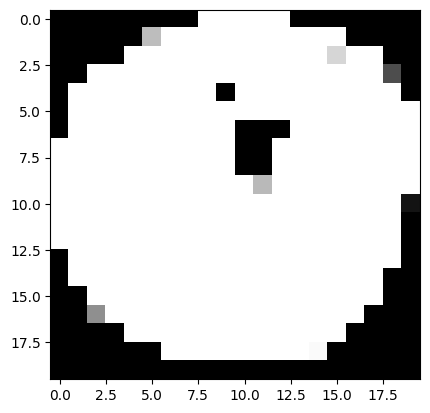

In [14]:
plt.imshow(resized_object, cmap='gray')

# Data Augmentation

In [15]:
def rotate_image(image, angle):
    rows, cols = image.shape
    M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, M, (cols, rows))
    return rotated_image

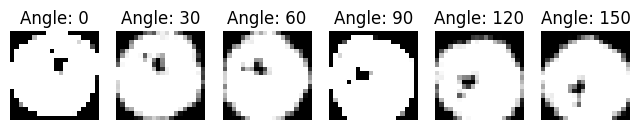

In [16]:
rotated_images = [resized_object]

# Góc xoay (đối với ví dụ này, bạn có thể thay đổi góc theo ý muốn)
angles = [30, 60, 90, 120, 150]

# Tạo các phiên bản xoay của ảnh gốc
for angle in angles:
    rotated = rotate_image(resized_object, angle)
    rotated_images.append(rotated)

# Hiển thị ảnh gốc và các phiên bản xoay
plt.figure(figsize=(8, 4))

for i in range(len(rotated_images)):
    plt.subplot(1, len(rotated_images), i + 1)
    plt.imshow(rotated_images[i], cmap='gray')
    plt.title(f'Angle: {angles[i-1] if i > 0 else 0}')
    plt.axis('off')

plt.show()

## Data Preprocess for all data

### Function check image in folder

In [17]:
def display_images_from_folder(folder_path, num_images=7, list_picture = [], compare = False):
    # Lấy danh sách các tệp tin trong thư mục
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg', '.gif'))]

    # Tạo subplot cho mỗi ảnh
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    
    if compare == True:
        i = 0
        for image_file in list_picture:
            image_file = f"{image_file.split('.')[0]}_{0}.{image_file.split('.')[1]}"
            image_path = os.path.join(folder_path, image_file)
            img = Image.open(image_path)
            axes[i].imshow(img, cmap = 'gray')
            axes[i].axis('off')
            axes[i].set_title(f'{image_file}')
            i += 1

        # Hiển thị biểu đồ
        plt.show()
    else:
        # Chỉ lấy số lượng ảnh cần hiển thị (num_images)
        image_files = image_files[:num_images]
        # List picture input
        list_picture = []
        # Hiển thị từng ảnh
        for i, image_file in enumerate(image_files):
            list_picture.append(image_file)
            image_path = os.path.join(folder_path, image_file)
            img = Image.open(image_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f'{image_file}')

        # Hiển thị biểu đồ
        plt.show()
        return list_picture

In [18]:
# Input folder path
input_folder = "/kaggle/input/tptn-object-shape-dataset/object-dataset/all"
# Output folder path
output_folder = "/kaggle/working/clean-data"

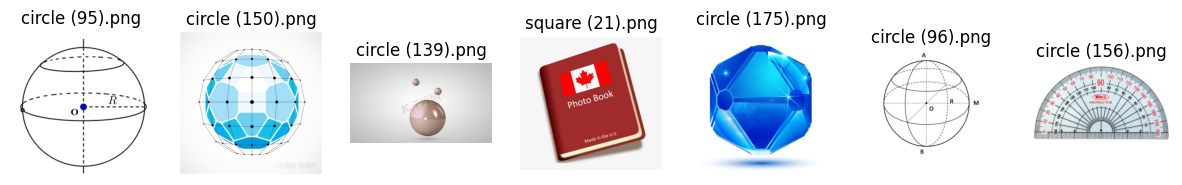

['circle (95).png',
 'circle (150).png',
 'circle (139).png',
 'square (21).png',
 'circle (175).png',
 'circle (96).png',
 'circle (156).png']

In [19]:
display_images_from_folder(input_folder)

In [20]:
# If output folder doesn't exsit, Create it
os.makedirs(output_folder, exist_ok=True)

In [21]:
for filename in tqdm(os.listdir(input_folder)):
    if filename.endswith(".png") or filename.endswith(".jpg"):
        
        # Read picture
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path)
        
        grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bin_pixels = cv2.threshold(grayscale_image, 200, 255, cv2.THRESH_BINARY)[1]
        bin_pixels = cv2.bitwise_not(bin_pixels)
        
        # Make contours around the binarized image, keep only the largest contour
        contours, _ = cv2.findContours(bin_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        contour = max(contours, key=cv2.contourArea)

        # Create a mask from the largest contour
        mask = np.zeros(bin_pixels.shape, np.uint8)
        cv2.drawContours(mask, [contour], -1, 255, cv2.FILLED)

        # Use bitwise_and to get masked part of the original image
        out = cv2.bitwise_and(bin_pixels, mask)

        # get bounding box of contour
        y1, y2 = np.min(contour[:, :, 1]), np.max(contour[:, :, 1])
        x1, x2 = np.min(contour[:, :, 0]), np.max(contour[:, :, 0])

        x1 = int(0.99 * x1)
        x2 = int(1.01 * x2)
        y1 = int(0.99 * y1)
        y2 = int(1.01 * y2)

        crop_pic = out[y1:y2, x1:x2]
        final_pic = cv2.resize(crop_pic, target_size)
        
        # Data argumentation
        rotated_final_images = [final_pic]

        # Góc xoay (đối với ví dụ này, bạn có thể thay đổi góc theo ý muốn)
        angles = [30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
        angles_cir = [45, 90, 135, 180, 225, 270, 305]
        
        # Tạo các phiên bản xoay của ảnh gốc
        if 'circle' in filename:
            # Giảm dữ liệu circle
            for angle in angles_cir:
                rotated = rotate_image(final_pic, angle)
                rotated_final_images.append(rotated)
        else:
            for angle in angles:
                rotated = rotate_image(final_pic, angle)
                rotated_final_images.append(rotated)

        # Lưu hình ảnh đã xử lý vào thư mục đầu ra
        for idx, final in enumerate(rotated_final_images):
            # Tạo tên file duy nhất bằng cách thêm chỉ số động vào tên file
            output_filename = f"{filename.split('.')[0]}_{idx}.{filename.split('.')[1]}"
            output_path = os.path.join(output_folder, output_filename)
            cv2.imwrite(output_path, final)


  0%|          | 0/336 [00:00<?, ?it/s]

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


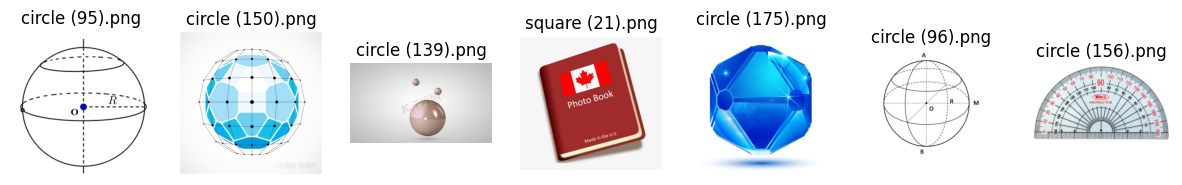

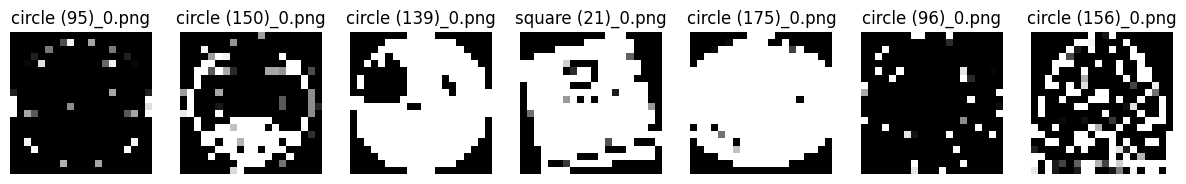

In [22]:
list_pic = display_images_from_folder(input_folder)
display_images_from_folder(output_folder, list_picture = list_pic, compare = True)


# Prepare data

In [23]:
img = cv2.imread("/kaggle/working/clean-data/circle (150)_0.png")
# Chuyển đổi ảnh về đen trắng
image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
print(image_gray.shape)
image_gray

(20, 20)


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 157,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 150,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0, 245,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 157, 255, 242,   0,   0,   0,   0,   0,   0,
          0, 255,   0,   0,   0,   0,   0],
       [  0,   0,   0, 255, 255,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0, 255, 255,   0,   0,   0],
       [  0,   0, 255, 255,  89, 255, 166,  41,   0,   0,   0,   0, 166,
        166, 147, 255, 255,   0,  75,   0],
       [  0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255,   0,   0],
       [  0,   0, 255,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0, 255,   0,   0],
       [157, 255,   0,   0,   0, 166,   0,   0,   0,   0,   0,  

In [24]:
count_zeros = np.sum(image_gray == 0)
ratio_black = count_zeros / (image_gray.shape[0] * image_gray.shape[1])
ratio_black

0.7225

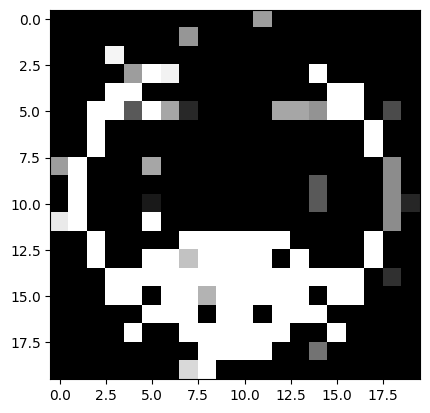

In [25]:
plt.imshow(image_gray, cmap = 'gray')

### Prepare data X, y

In [26]:
input_data = '/kaggle/working/clean-data'
X = []
y = []
for filename in tqdm(os.listdir(input_data)):
    if filename.endswith(".png") or filename.endswith(".jpg"):

        # Read picture
        img_path = os.path.join(input_data, filename)
        img = cv2.imread(img_path)
        # convert size x size x 3 => size x size
        image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        count_zeros = np.sum(image_gray == 0)
        ratio_black = count_zeros / (image_gray.shape[0] * image_gray.shape[1])
        if ratio_black > 0.75:
            continue
        
#         print(image_gray.shape)
        X.append(image_gray)
        if 'circle' in filename:
            y.append(0)
        elif 'square' in filename:
            y.append(1)
        else:
            y.append(2)
            
X = np.array(X)
y = np.array(y)
print(X.shape)
print(y.shape)

  0%|          | 0/3368 [00:00<?, ?it/s]

(2993, 20, 20)
(2993,)


In [27]:
X

array([[[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0, 104, ...,  24,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ..., 112,   0,   0],
        [  0,   0,  16, ..., 239,  16,   0],
        ...,
        [  0,   0,   0, ..., 112,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]],

       ...,

       [[  0,   0,   0, ...,   0,   0,   0],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

In [28]:
y

array([0, 2, 1, ..., 1, 2, 1])

In [29]:
X = X.reshape((X.shape[0], -1)) / 255
print(X.shape)

(2993, 400)


## Balance data

In [30]:
n_circle = np.sum(y == 0)
n_square = np.sum(y == 1)
n_triangle = np.sum(y == 2)

In [31]:
print(n_circle, n_square, n_triangle)

1183 776 1034


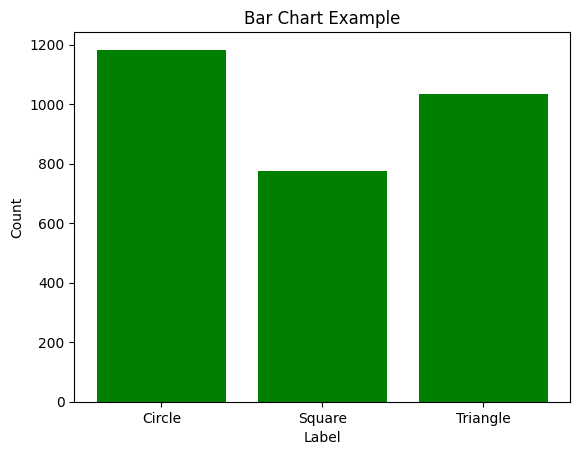

In [32]:
data = [n_circle, n_square, n_triangle]

# Xác định các vị trí của các cột trên trục x
x_positions = ['Circle', 'Square', 'Triangle']

# Vẽ biểu đồ cột
plt.bar(x_positions, data, color='green')

# Đặt tên cho trục x và trục y
plt.xlabel('Label')
plt.ylabel('Count')

# Đặt tên cho biểu đồ
plt.title('Bar Chart Example')

# Hiển thị biểu đồ
plt.show()


# Split train/test

In [33]:
# Giả sử X là dữ liệu đặc trưng (336, 784) và y là nhãn (336,)
# Thực hiện chia tập dữ liệu thành tập huấn luyện và tập kiểm tra (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kiểm tra kích thước của các tập dữ liệu
print("Kích thước train X:", X_train.shape)
print("Kích thước test X:", X_test.shape)
print("Kích thước train y:", y_train.shape)
print("Kích thước test y:", y_test.shape)

Kích thước train X: (2394, 400)
Kích thước test X: (599, 400)
Kích thước train y: (2394,)
Kích thước test y: (599,)


### One hot for train label

In [34]:
y_one_hot = np.zeros((len(y_train), 3))
for i in range(len(y_train)):
    y_one_hot[i, y_train[i]] = 1
print('Shape of X_train:', X_train.shape)
print('Shape of y_one_hot:', y_one_hot.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (2394, 400)
Shape of y_one_hot: (2394, 3)
Shape of X_test: (599, 400)
Shape of y_test: (599,)


# Model architecture theory

# Hàm tanh

$\tanh(x) = \dfrac{2}{1 + e^{-2x}} - 1 = \dfrac {1 - e^{-2x}}  {1 + e^{-2x}}$

$\begin{array}l
tanh'(x) &=& -\dfrac{2 (1 + e^{-2x})'}{(1 + e^{-2x})^2}  \\
&=&  -\dfrac{-4 e^{-2x}}{(1 + e^{-2x})^2} \\
&=&  \dfrac{2e^{-2x} + e^{-4x} + 1 - e^{-4x} - 1 + 2e^{-2x}} {(1 + e^{-2x})^2} \\
&=& \dfrac {(1+e^{-2x})^2 - (1-e^{2x})^2} {(1 + e^{-2x})^2} \\
&=& 1 - \dfrac {(1-e^{2x})^2} {(1 + e^{-2x})^2} \\
&=& 1 - (\dfrac {1-e^{2x}} {1 + e^{-2x}})^2 \\
&=& 1 - tanh^2(x)
\end{array}$

In [35]:
def tanh(x):
    return 2 / (1 + np.exp(-2 * x)) - 1

def tanh_derivative(x):
    return 1 - tanh(x)**2

# Hàm ReLU

$ReLU(x) = max(0, x) ⇒ ReLU'(x) = \left\{\begin{matrix}
0, & \text{if} & x\leq0 \\ 1, & \text{if} & x>0 \end{matrix}\right.$


In [36]:
def relu(x):
    return np.maximum(x * 1e-3 , x)

def relu_derivative(x):
    return np.where(x > 0, 1, 1e-3)

# Hàm Sigmoid
$ \sigma(x) = \dfrac 1 {1+ e^{-x}} $

$\begin{array}l
\sigma'(x) &=& -\dfrac {(1+e^{-x)'}} {(1+ e^{-x})^2} \\
&=& - \dfrac {-e^{-x}} {{(1+ e^{-x})^2}} \\
&=& \dfrac {e^{-x}} {{(1+ e^{-x})^2}} \\
&=& \dfrac 1 {1+ e^{-x}} . \dfrac {e^{-x}} {1+ e^{-x}} \\
&=& \dfrac 1 {1+ e^{-x}} . \dfrac {1+e^{-x}-1} {1+ e^{-x}} \\
&=& \dfrac 1 {1+ e^{-x}} . (\dfrac {1+e^{-x}} {1+ e^{-x}} - \dfrac 1 {1+ e^{-x}}) \\ \\
&=& \sigma(x)  (1-\sigma(x))
\end{array}$

In [37]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Activation function in GPU

In [38]:
# Chuyển đổi dữ liệu sang tensor và di chuyển lên GPU nếu có
def to_tensor_and_device(data, device):
    return torch.tensor(data, dtype=torch.float32, device=device)
def GPUsigmoid(x):
    return 1 / (1 + torch.exp(-x))

def GPUsigmoid_derivative(x):
    return GPUsigmoid(x) * (1 - GPUsigmoid(x))

def GPUtanh(x):
    return 2 / (1 + torch.exp(-2 * x)) - 1

def GPUtanh_derivative(x):
    return 1 - GPUtanh(x)**2

# Kiến trúc mạng Model 1:

| Lớp         | Shape: (m,n)| Params = m * (n+1)  | Activation Function|
|-------------|------------|--------|---------|
| 1   | (784, 128) | 101136 | tanh
| 2           | (128, 32)  | 8320   | tanh
| output  | (32, 10)   | 352    | sigmoid

Tổng tham số: $111,920$

Để dễ trình bày hơn, gọi $x = (\text{input}, 1)$ , $w_i = (\text{weights}_i, \text{bias}_i)$

## Forward:

 - $a_1 = tanh(w_1x)$
 - $a_2 = tanh(w_2a_1)$
 - $a_3 = σ(w_3a_2)$

##  Backgropagation
Ta có hàm Loss:  

 $\begin{array}l 𝓛 &=& \frac 1 2(y - \hat y)^2 & \\
                  &=&  \frac 1 2(y - σ(w_3a_2))^2 & (𝟙) \\
                  &=&  \frac 1 2(y- σ(w_3.tanh(w_2a_1))^2 & (2) \\
                  &=& \frac 1 2(y- σ(w_3.tanh(w_2.tanh(w_1x))^2 & (3)
\end{array}$

$\Rightarrow$ Mục tiêu là làm cho hàm 𝓛 nhỏ nhất. Thực hiện gradient descent

$\begin{array}l
\\ (𝟙) ⇒ & \nabla 𝓛_{w_{3}}  &=&  - {a_2}^T.(y - \hat y)  . σ(w_3a_2) (𝟙 -  σ(w_3a_2)) \\
& &=& - {a_2}^T .(y - \hat y) . \hat y (𝟙 -  \hat y) \\
& w_3 &=& w_3 - \nabla 𝓛_{w_{3}} \\
&  &=& w_3 + {a_2}^T. (y - \hat y) . \hat y (𝟙 -  \hat y) \\ \\
\end{array} $

$ \begin{array}l
(2) ⇒ & \nabla 𝓛_{w_2} &=&  - (y - \hat y).  σ(w_3.tanh(w_2a_1))' \\
& &=& - (y - \hat y). σ(w_3.tanh(w_2a_1)).[𝟙-σ(w_3.tanh(w_2a_1))] . tanh'(w_2a_1) \\
& &=& - {a_1}^T . [𝟙-tanh^2(w_2a_1)].(y - \hat y). σ(w_3.tanh(w_2a_1)).[𝟙-σ(w_3.tanh(w_2a_1)]\\
& &=& - {a_1}^T . [𝟙-tanh^2(a_2)].(y - \hat y).\hat y (𝟙 -  \hat y)  \\
& w_2 &=& w_2 - \nabla 𝓛_{w_{2}} \\
& &=& w_2 + {a_1}^T . (1-tanh^2(a_2)).(y - \hat y).\hat y (𝟙 -  \hat y) \\ \\
\end{array}
$

$\begin{array}l
(3)⇒ &   \nabla 𝓛_{w_1} &=&  - tanh'(w_2.tanh(w_1x)). (y - \hat y)  σ(w_3.tanh(w_2.tanh(w_1x))) [𝟙- σ(w_3.tanh(w_2.tanh(w_1x)] \\
& &=& - tanh'(w_1x)(𝟙-tanh^2(a_2)). (y - \hat y)  \hat y (𝟙 -  \hat y) \\
& &=& - x^T .(𝟙-tanh^2(w_1x)). (𝟙-tanh^2(a_2)) . (y - \hat y)  \hat y (𝟙 -  \hat y) \\
& w_1 &=& w_1 - \nabla 𝓛_{w_{1}} \\
& &=& w_2 + x^T .(𝟙-tanh^2(w_1x)). (𝟙-tanh^2(a_2)) . (y - \hat y)  \hat y (𝟙 -  \hat y)
\end{array}$

# Build Model 1

### CPU

In [39]:
class CPU_NeuralNetwork_1:
    def __init__(self):
        self.w1 = np.random.rand(target_size[0]*target_size[0], 128)
        self.b1 = np.zeros((1, 128))

        self.w2 = np.random.rand(128, 32)
        self.b2 = np.zeros((1, 32))

        self.w_output = np.random.rand(32, 3)
        self.b_output = np.zeros((1, 3))

    def forward(self, input_data):
        self.layer1 = tanh(input_data @ self.w1 + self.b1)
        self.layer2 = tanh(self.layer1 @ self.w2 + self.b2)
        self.output = sigmoid(self.layer2 @ self.w_output + self.b_output)
        return self.output

    def backpropagate(self, input_data, error, learning_rate):
        output_delta = error * sigmoid_derivative(self.output)
        # print(self.output, sigmoid_derivative(self.output))

        layer2_error = output_delta @ self.w_output.T
        layer2_delta = layer2_error * tanh_derivative(self.layer2)

        layer1_error = layer2_delta @ self.w2.T
        layer1_delta = layer1_error * tanh_derivative(self.layer1)

        self.w_output += self.layer2.T @ output_delta * learning_rate
        self.b_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate

        self.w2 += self.layer1.T @ layer2_delta * learning_rate
        self.b2 += np.sum(layer2_delta, axis=0, keepdims=True) * learning_rate

        self.w1 += input_data.T @ layer1_delta * learning_rate
        self.b1 += np.sum(layer1_delta, axis=0, keepdims=True) * learning_rate


    def train(self, input_data, target_output, test_data, test_label, learning_rate=0.01, epochs=1000, ):
        self.loss = []
        N = len(target_output)
        max_acc = 0
        for epoch in tqdm(range(1, epochs+1)):
            self.output = self.forward(input_data)
            error = target_output - self.output
            loss = (error**2).sum()**0.5 / N
            self.loss.append(loss)
            self.backpropagate(input_data, error, learning_rate)

            # Đánh giá
            output_test = self.forward(test_data)
            predictions = np.argmax(output_test, axis=1)
            accuracy = accuracy_score(test_label, predictions)
            if epoch % 200 == 0:
                if accuracy > max_acc:
                    max_acc = accuracy
                    print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f} => Best Model✔️")
                else:
                    print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

### GPU

In [40]:
class GPU_NeuralNetwork_1(nn.Module):
    def __init__(self):
        super(GPU_NeuralNetwork_1, self).__init__()
        self.w1 = nn.Parameter(torch.rand(target_size[0]*target_size[0], 128, dtype=torch.float32))
        self.b1 = nn.Parameter(torch.zeros(1, 128, dtype=torch.float32))

        self.w2 = nn.Parameter(torch.rand(128, 32, dtype=torch.float32))
        self.b2 = nn.Parameter(torch.zeros(1, 32, dtype=torch.float32))

        self.w_output = nn.Parameter(torch.rand(32, 3, dtype=torch.float32))
        self.b_output = nn.Parameter(torch.zeros(1, 3, dtype=torch.float32))

    def forward(self, input_data):
        self.layer1 = torch.tanh(input_data @ self.w1 + self.b1)
        self.layer2 = torch.tanh(self.layer1 @ self.w2 + self.b2)
        self.output = torch.sigmoid(self.layer2 @ self.w_output + self.b_output)
        return self.output
    
    def backpropagate(self, input_data, error, learning_rate):
        output_delta = error * GPUsigmoid_derivative(self.output)

        layer2_error = output_delta @ self.w_output.T
        layer2_delta = layer2_error * GPUtanh_derivative(self.layer2)

        layer1_error = layer2_delta @ self.w2.T
        layer1_delta = layer1_error * GPUtanh_derivative(self.layer1)

        # Sử dụng torch.nn.functional để thay đổi giá trị của các tham số
        self.w_output.data += self.layer2.T @ output_delta * learning_rate
        self.b_output.data += torch.sum(output_delta, dim=0, keepdim=True) * learning_rate

        self.w2.data += self.layer1.T @ layer2_delta * learning_rate
        self.b2.data += torch.sum(layer2_delta, dim=0, keepdim=True) * learning_rate

        self.w1.data += input_data.T @ layer1_delta * learning_rate
        self.b1.data += torch.sum(layer1_delta, dim=0, keepdim=True) * learning_rate

    def train(self, input_data, target_output, test_data, test_label, learning_rate=0.01, epochs=1000):
        self.to(device)

#         criterion = nn.MSELoss()
#         optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        input_data = to_tensor_and_device(input_data, device)
        target_output = to_tensor_and_device(target_output, device)
        test_data = to_tensor_and_device(test_data, device)

        self.loss = []
        N = len(target_output)
        max_acc = 0
        for epoch in tqdm(range(1, epochs+1)):
            self.output = self.forward(input_data)
            error = target_output - self.output
            loss = (error**2).sum()**0.5 / N
            self.loss.append(loss)
            self.backpropagate(input_data, error, learning_rate)

            # Đánh giá
            output_test = self.forward(test_data)
            predictions = torch.argmax(output_test, axis=1).cpu()
            accuracy = accuracy_score(test_label, predictions)
            if epoch % 200 == 0:
                if accuracy > max_acc:
                    max_acc = accuracy
                    print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f} => Best Model✔️")
                else:
                    print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Train Model 1 in CPU

In [41]:
CPUnn1 = CPU_NeuralNetwork_1()
# Huấn luyện mô hình
CPUnn1.train(X_train, y_one_hot, X_test, y_test, learning_rate=1e-5, epochs=7000)

  0%|          | 0/7000 [00:00<?, ?it/s]

Epoch 200/7000, Loss: 0.0184, Accuracy: 0.4674 => Best Model✔️
Epoch 400/7000, Loss: 0.0155, Accuracy: 0.5526 => Best Model✔️
Epoch 600/7000, Loss: 0.0153, Accuracy: 0.5476
Epoch 800/7000, Loss: 0.0152, Accuracy: 0.5576 => Best Model✔️
Epoch 1000/7000, Loss: 0.0150, Accuracy: 0.5676 => Best Model✔️
Epoch 1200/7000, Loss: 0.0148, Accuracy: 0.5826 => Best Model✔️
Epoch 1400/7000, Loss: 0.0147, Accuracy: 0.5977 => Best Model✔️
Epoch 1600/7000, Loss: 0.0145, Accuracy: 0.6144 => Best Model✔️
Epoch 1800/7000, Loss: 0.0144, Accuracy: 0.6227 => Best Model✔️
Epoch 2000/7000, Loss: 0.0143, Accuracy: 0.6277 => Best Model✔️
Epoch 2200/7000, Loss: 0.0141, Accuracy: 0.6394 => Best Model✔️
Epoch 2400/7000, Loss: 0.0140, Accuracy: 0.6444 => Best Model✔️
Epoch 2600/7000, Loss: 0.0139, Accuracy: 0.6294
Epoch 2800/7000, Loss: 0.0138, Accuracy: 0.6294
Epoch 3000/7000, Loss: 0.0138, Accuracy: 0.6277
Epoch 3200/7000, Loss: 0.0138, Accuracy: 0.6260
Epoch 3400/7000, Loss: 0.0138, Accuracy: 0.6194
Epoch 3600/7

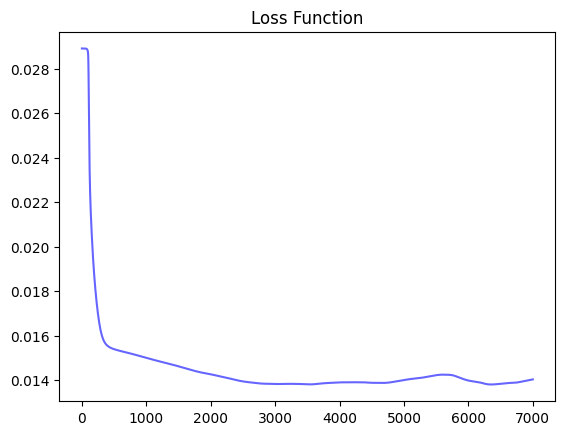

In [42]:
plt.plot(range(len(CPUnn1.loss)), CPUnn1.loss, color='blue', alpha=0.6)
plt.title('Loss Function')
plt.show()

# Train Model 1 in GPU

In [43]:
# GPUnn1 = GPU_NeuralNetwork_1()
# # Huấn luyện mô hình
# GPUnn1.train(X_train, y_one_hot, X_test, y_test, learning_rate=1e-5, epochs=6000)

In [44]:
# GPUnn1.loss[0].item

In [45]:
# loss_cpu = [loss.item() for loss in GPUnn1.loss]

# # Vẽ đồ thị
# plt.plot(range(len(loss_cpu)), loss_cpu, color='blue', alpha=0.6)
# plt.title('Loss Function')
# plt.show()

# Infer Model 1 in CPU

In [83]:
import numpy as np

index_predict = 3
# Assume you have input_data that you want to predict
input_data_to_predict = X_test[index_predict] # Replace this with your actual input data

# Load your trained weights and biases here if needed
# For example, model.w1 = loaded_w1, model.b1 = loaded_b1, etc.

# Use the forward method to make predictions
predictions = CPUnn1.forward(input_data_to_predict)
predictions = np.argmax(predictions, axis=1)

convert_predict = {0 : 'circle', 1 : 'square', 2 : 'triangle'}

# Print or use the predictions as needed
print("Predictions:", convert_predict[predictions[0]])

Predictions: square


In [84]:
convert_predict[y_test[index_predict]]

'square'

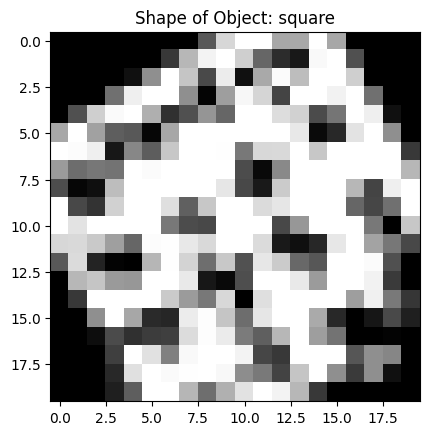

In [85]:
plt.imshow(input_data_to_predict.reshape((target_size[0], target_size[1])), cmap='gray')
plt.title(f'Shape of Object: {convert_predict[y_test[index_predict]]}')
plt.show()

# Infer Model 1 in GPU

In [86]:
# # Convert input_data_to_predict to a PyTorch tensor
# input_data_to_predict = torch.tensor(input_data_to_predict, dtype=torch.float32, device=device)

# # Use the forward method to make predictions
# predictions = GPUnn1.forward(input_data_to_predict)
# predictions = np.argmax(predictions.cpu().detach().numpy(), axis=1)
# convert_predict = {0 : 'circle', 1 : 'square', 2 : 'triangle'}

# # Print or use the predictions as needed
# print("Predictions:", convert_predict[predictions[0]])

In [87]:
# convert_predict[y_test[index_predict]]

In [88]:
# plt.imshow(input_data_to_predict.cpu().reshape((target_size[0], target_size[1])), cmap='gray')
# plt.title(f'Shape of Object: {convert_predict[y_test[index_predict]]}')
# plt.show()

# Kiến trúc mạng Model 2:

| Lớp         | Shape: (m,n)| Params = m * (n+1)  | Activation Function|
|-------------|------------|--------|---------|
| 1   | (400, 128) | 51600 | tanh
| 2           | (128, 56)  | 7296   | tanh
| 3           | (56, 12)  | 728   | tanh
| 4 | (12, 32)| 396 | tanh
| output  | (32, 10)   | 352    | sigmoid

Tổng tham số: $60572$

Để dễ trình bày hơn, gọi $x = (\text{input}, 1)$ , $w_i = (\text{weights}_i, \text{bias}_i)$

## Forward:

 - $a_1 = tanh(w_1x)$
 - $a_2 = tanh(w_2a_1)$
 - $a_3 = tanh(w_3a_2)$
 - $a_4 = tanh(w_4a_3)$
 - $a_5 = σ(w_5a_4)$



# Ảnh 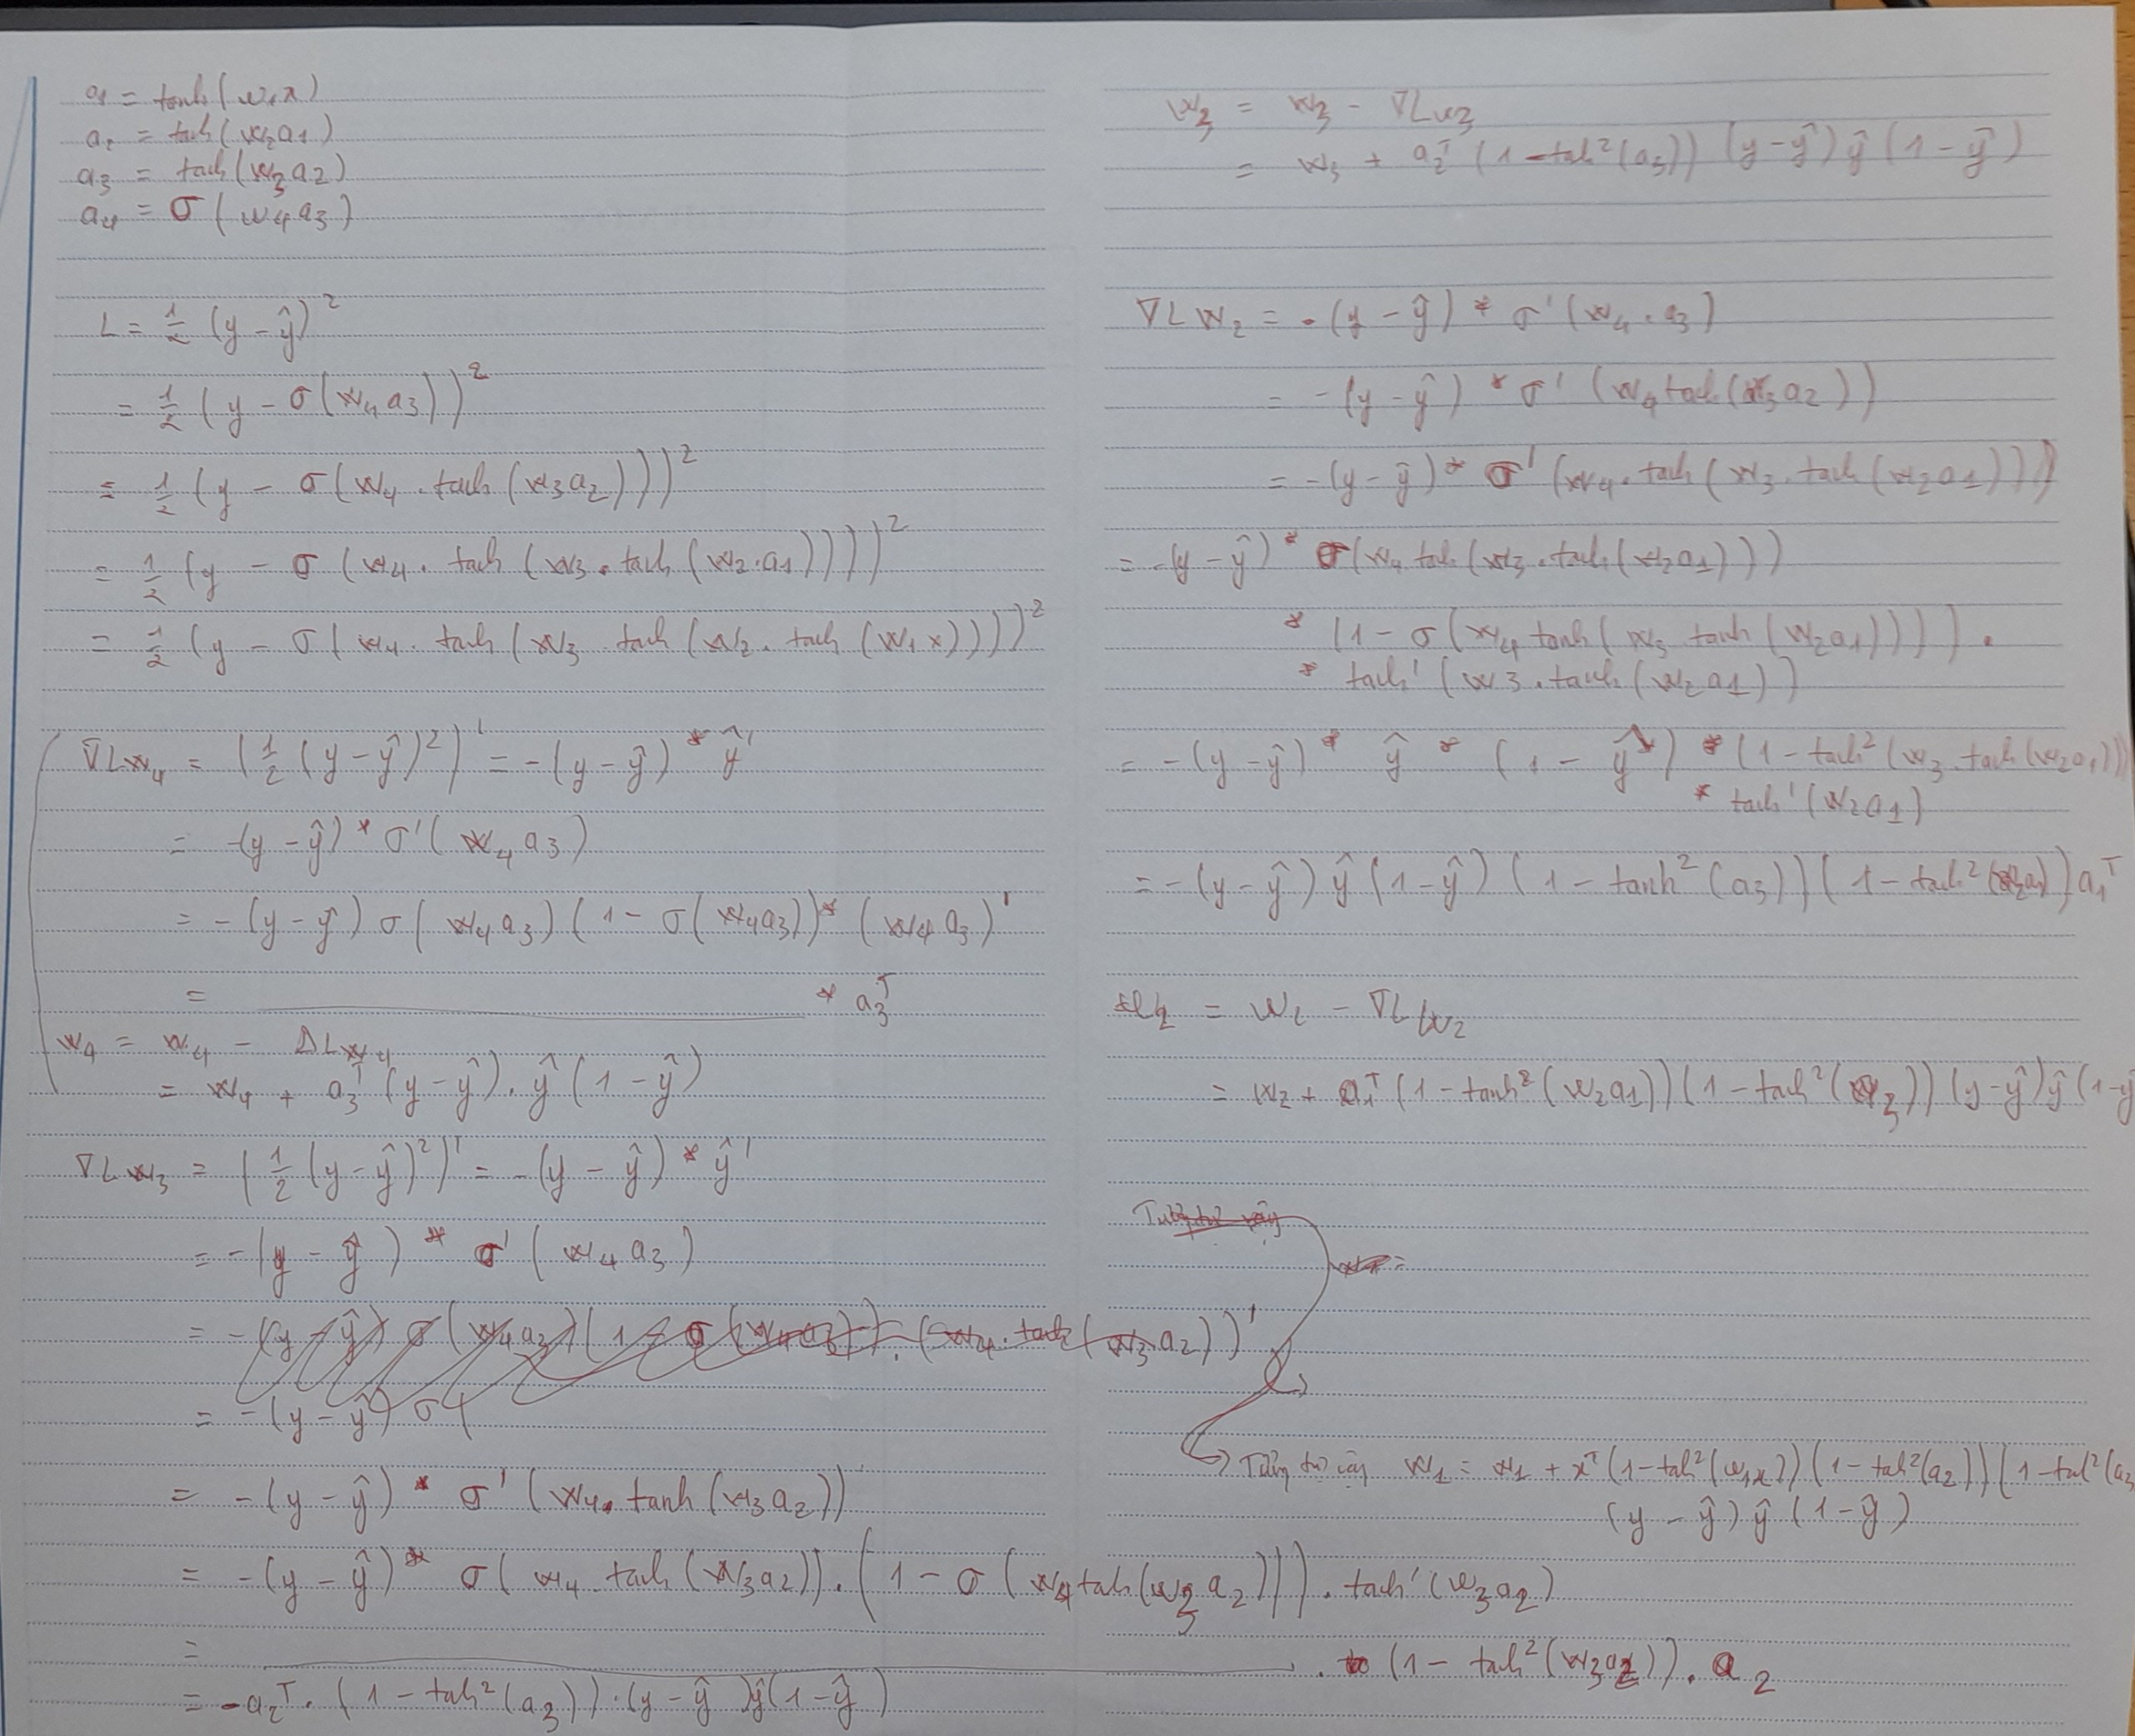

# Build Model 2

In [52]:
class GPU_NeuralNetwork_2(nn.Module):
    def __init__(self):
        #4727
        super(GPU_NeuralNetwork_2, self).__init__()
        self.w1 = nn.Parameter(torch.rand(target_size[0]*target_size[0], 128, dtype=torch.float32))
        self.b1 = nn.Parameter(torch.zeros(1, 128, dtype=torch.float32))

        self.w2 = nn.Parameter(torch.rand(128, 56, dtype=torch.float32))
        self.b2 = nn.Parameter(torch.zeros(1, 56, dtype=torch.float32))
        
        self.w3 = nn.Parameter(torch.rand(56, 12, dtype=torch.float32))
        self.b3 = nn.Parameter(torch.zeros(1, 12, dtype=torch.float32))
        
        self.w4 = nn.Parameter(torch.rand(12, 32, dtype=torch.float32))
        self.b4 = nn.Parameter(torch.zeros(1, 32, dtype=torch.float32))

        self.w_output = nn.Parameter(torch.rand(32, 3, dtype=torch.float32))
        self.b_output = nn.Parameter(torch.zeros(1, 3, dtype=torch.float32))

    def forward(self, input_data):
        self.layer1 = torch.tanh(input_data @ self.w1 + self.b1)
        self.layer2 = torch.tanh(self.layer1 @ self.w2 + self.b2)
        self.layer3 = torch.tanh(self.layer2 @ self.w3 + self.b3)
        self.layer4 = torch.tanh(self.layer3 @ self.w4 + self.b4)
        self.output = torch.sigmoid(self.layer4 @ self.w_output + self.b_output)
        return self.output
    
    def backpropagate(self, input_data, error, learning_rate):
        output_delta = error * GPUsigmoid_derivative(self.output)

        layer4_error = output_delta @ self.w_output.T
        layer4_delta = layer4_error * GPUtanh_derivative(self.layer4)
        
        layer3_error = layer4_delta @ self.w4.T
        layer3_delta = layer3_error * GPUtanh_derivative(self.layer3)
        
        layer2_error = layer3_delta @ self.w3.T
        layer2_delta = layer2_error * GPUtanh_derivative(self.layer2)
        
        layer1_error = layer2_delta @ self.w2.T
        layer1_delta = layer1_error * GPUtanh_derivative(self.layer1)

        # Sử dụng torch.nn.functional để thay đổi giá trị của các tham số
        self.w_output.data += self.layer4.T @ output_delta * learning_rate
        self.b_output.data += torch.sum(output_delta, dim=0, keepdim=True) * learning_rate

        self.w4.data += self.layer3.T @ layer4_delta * learning_rate
        self.b4.data += torch.sum(layer4_delta, dim=0, keepdim=True) * learning_rate
        
        self.w3.data += self.layer2.T @ layer3_delta * learning_rate
        self.b3.data += torch.sum(layer3_delta, dim=0, keepdim=True) * learning_rate
        
        self.w2.data += self.layer1.T @ layer2_delta * learning_rate
        self.b2.data += torch.sum(layer2_delta, dim=0, keepdim=True) * learning_rate

        self.w1.data += input_data.T @ layer1_delta * learning_rate
        self.b1.data += torch.sum(layer1_delta, dim=0, keepdim=True) * learning_rate

    def train(self, input_data, target_output, test_data, test_label, learning_rate=0.01, epochs=1000):
        self.to(device)

#         criterion = nn.MSELoss()
#         optimizer = optim.SGD(self.parameters(), lr=learning_rate)

        input_data = to_tensor_and_device(input_data, device)
        target_output = to_tensor_and_device(target_output, device)
        test_data = to_tensor_and_device(test_data, device)

        self.loss = []
        N = len(target_output)
        max_acc = 0
        for epoch in tqdm(range(1, epochs+1)):
            self.output = self.forward(input_data)
            error = target_output - self.output
            loss = (error**2).sum()**0.5 / N
            self.loss.append(loss)
            self.backpropagate(input_data, error, learning_rate)

            # Đánh giá
            output_test = self.forward(test_data)
            predictions = torch.argmax(output_test, axis=1).cpu()
            accuracy = accuracy_score(test_label, predictions)
            
            if epoch % 200 == 0:
                if accuracy > max_acc:
                    max_acc = accuracy
                    print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f} => Best Model✔️")
                else:
                    print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

# Train Model 2 on GPU

In [53]:
GPUnn2 = GPU_NeuralNetwork_2()
# Huấn luyện mô hình
GPUnn2.train(X_train, y_one_hot, X_test, y_test, learning_rate=1e-5, epochs=6000)

  0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 200/6000, Loss: 0.0166, Accuracy: 0.4207 => Best Model✔️
Epoch 400/6000, Loss: 0.0165, Accuracy: 0.4190
Epoch 600/6000, Loss: 0.0165, Accuracy: 0.4240 => Best Model✔️
Epoch 800/6000, Loss: 0.0165, Accuracy: 0.4324 => Best Model✔️
Epoch 1000/6000, Loss: 0.0166, Accuracy: 0.5008 => Best Model✔️
Epoch 1200/6000, Loss: 0.0165, Accuracy: 0.4541
Epoch 1400/6000, Loss: 0.0164, Accuracy: 0.5042 => Best Model✔️
Epoch 1600/6000, Loss: 0.0160, Accuracy: 0.5209 => Best Model✔️
Epoch 1800/6000, Loss: 0.0143, Accuracy: 0.6210 => Best Model✔️
Epoch 2000/6000, Loss: 0.0135, Accuracy: 0.6411 => Best Model✔️
Epoch 2200/6000, Loss: 0.0133, Accuracy: 0.6711 => Best Model✔️
Epoch 2400/6000, Loss: 0.0124, Accuracy: 0.6711
Epoch 2600/6000, Loss: 0.0117, Accuracy: 0.6912 => Best Model✔️
Epoch 2800/6000, Loss: 0.0112, Accuracy: 0.6962 => Best Model✔️
Epoch 3000/6000, Loss: 0.0109, Accuracy: 0.7078 => Best Model✔️
Epoch 3200/6000, Loss: 0.0105, Accuracy: 0.7095 => Best Model✔️
Epoch 3400/6000, Loss: 0.010

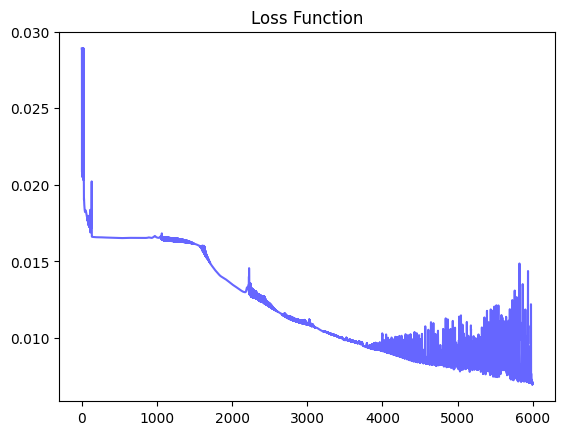

In [54]:
loss_cpu = [loss.item() for loss in GPUnn2.loss]

# Vẽ đồ thị
plt.plot(range(len(loss_cpu)), loss_cpu, color='blue', alpha=0.6)
plt.title('Loss Function')
plt.show()

# Infer Model 2 on GPU

In [92]:
# Convert input_data_to_predict to a PyTorch tensor
index_predict = 2
# Assume you have input_data that you want to predict
input_data_to_predict = X_test[index_predict] # Replace this with your actual input data
input_data_to_predict = torch.tensor(input_data_to_predict, dtype=torch.float32, device=device)

# Use the forward method to make predictions
predictions = GPUnn2.forward(input_data_to_predict)
predictions = np.argmax(predictions.cpu().detach().numpy(), axis=1)
convert_predict = {0 : 'circle', 1 : 'square', 2 : 'triangle'}

# Print or use the predictions as needed
print("Predictions:", convert_predict[predictions[0]])

Predictions: circle


In [93]:
convert_predict[y_test[index_predict]]

'circle'

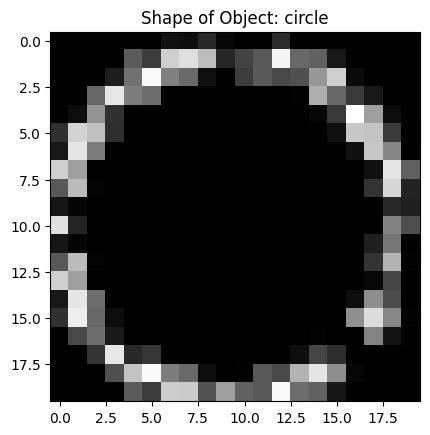

In [94]:
plt.imshow(input_data_to_predict.cpu().reshape((target_size[0], target_size[1])), cmap='gray')
plt.title(f'Shape of Object: {convert_predict[y_test[index_predict]]}')
plt.show()

# Predict from real data

### Get data

In [101]:
image_url = "/kaggle/input/salmons-object-dataset/dataset/tam1.png"

## Processing

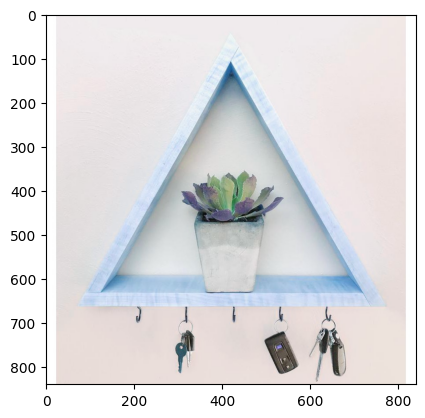

In [103]:
image = cv2.imread(image_url)
plt.imshow(image)
pre_grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
pre_bin_pixels = cv2.threshold(pre_grayscale_image, 200, 255, cv2.THRESH_BINARY)[1]
pre_bin_pixels = cv2.bitwise_not(pre_bin_pixels)

# Make contours around the binarized image, keep only the largest contour
pre_contours, _ = cv2.findContours(pre_bin_pixels, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
pre_contour = max(pre_contours, key=cv2.contourArea)

# Create a mask from the largest contour
pre_mask = np.zeros(pre_bin_pixels.shape, np.uint8)
cv2.drawContours(pre_mask, [pre_contour], -1, 255, cv2.FILLED)

# Use bitwise_and to get masked part of the original image
pre_out = cv2.bitwise_and(pre_bin_pixels, pre_mask)

# get bounding box of contour
y1, y2 = np.min(pre_contour[:, :, 1]), np.max(pre_contour[:, :, 1])
x1, x2 = np.min(pre_contour[:, :, 0]), np.max(pre_contour[:, :, 0])

x1 = int(0.99 * x1)
x2 = int(1.01 * x2)
y1 = int(0.99 * y1)
y2 = int(1.01 * y2)

pre_crop_pic = pre_out[y1:y2, x1:x2]
pre_final_pic = cv2.resize(pre_crop_pic, target_size)

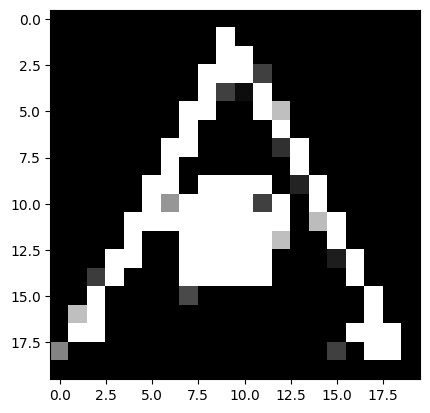

In [104]:
plt.imshow(pre_final_pic, cmap = 'gray')

### Reshape

In [105]:
print(pre_final_pic.shape)
pre_final_pic = pre_final_pic.reshape(400,) / 255
pre_final_pic.shape

(20, 20)


(400,)

In [106]:
input_data_to_predict = pre_final_pic
input_data_to_predict = torch.tensor(input_data_to_predict, dtype=torch.float32, device=device)

# Use the forward method to make predictions
predictions = GPUnn2.forward(input_data_to_predict)
predictions = np.argmax(predictions.cpu().detach().numpy(), axis=1)
convert_predict = {0 : 'circle', 1 : 'square', 2 : 'triangle'}

# Print or use the predictions as needed
print("Predictions:", convert_predict[predictions[0]])

Predictions: triangle
